In [21]:
# Imports
%matplotlib notebook
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver

In [10]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)
R = 0 * np.eye(4) # covarience matrix for image-space noise


<IPython.core.display.Javascript object>


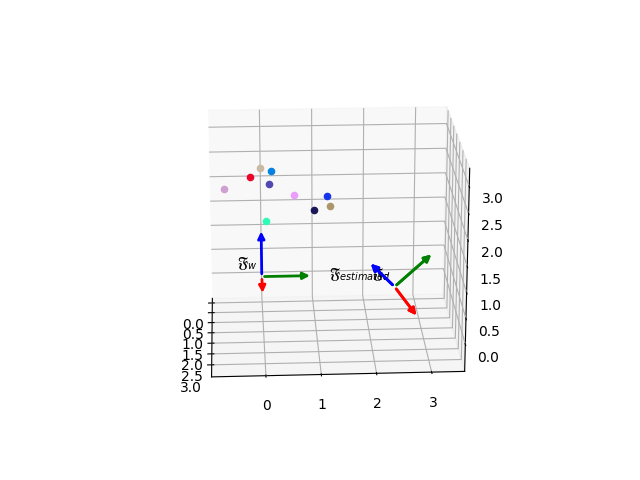

<IPython.core.display.Javascript object>


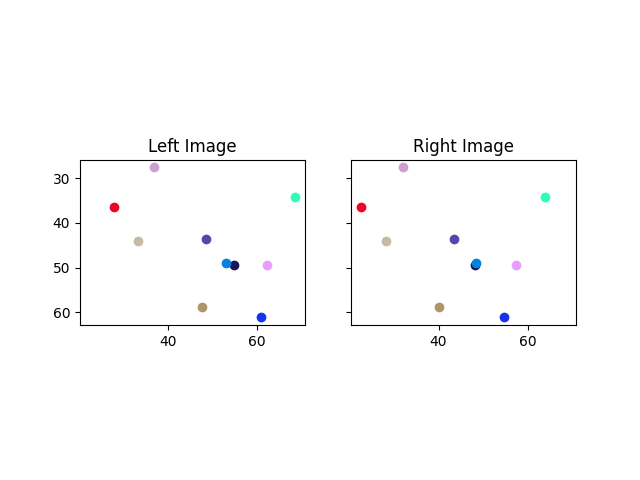

In [11]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 10
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
dy = sim.generate_stereo_camera_noise(R, size = 10)[:, :, None]
y = y + dy
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [12]:
T_op = np.eye(4)
W = np.eye(4)

max_iters = 1000
perturb_mag = np.inf

T_op = local_solver.stereo_localization_gauss_newton(T_op, y, p_w, W, M)

print("Estimate:\n", T_op)
print("Ground Truth:\n", T_cw)

Loss: 19558.15710796147
Loss: 132.5136447893068
Loss: 1.253643483972442
Loss: 1.7774950713273775e-05
Loss: 2.036457449019347e-15
Loss: 6.904110642494295e-27
Loss: 1.2571287385602044e-26
Estimate:
 [[ 0.87904402  0.37826243 -0.29017089 -1.55796856]
 [-0.1106191   0.75387831  0.64763485 -1.8516504 ]
 [ 0.46372947 -0.5372011   0.70453527  1.06043833]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.87904402  0.37826243 -0.29017089 -1.55796856]
 [-0.1106191   0.75387831  0.64763485 -1.8516504 ]
 [ 0.46372947 -0.5372011   0.70453527  1.06043833]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


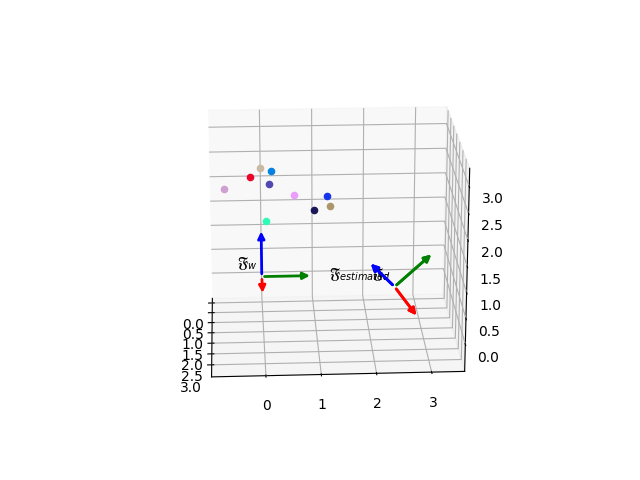

In [13]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation

See `math.tex`


In [5]:
import sympy as sy

In [38]:
def vectorize(A):
    return A.reshape(np.prod(A.shape), 1)

In [78]:
# symbols for T
R = sy.MatrixSymbol('R', 3, 3)
R = sy.Matrix(R)
r = sy.MatrixSymbol('r', 3, 1)
r = sy.Matrix(r)
vectorize(R).col_join(r)

w_0, w_1 = sy.symbols('\omega_0, \omega_1')
N = 2 # number of points
vs = []
ys = []
ps = []
for i in range(N):
    vs.append(sy.Matrix(sy.MatrixSymbol(f'v_{i}', 4, 1)))
    ys.append(sy.Matrix(sy.MatrixSymbol(f'y_{i}', 4, 1)))
    ps.append(sy.Matrix(sy.MatrixSymbol(f'p_{i}', 4, 1)))
    
T = sy.BlockMatrix([[R, r], [sy.zeros(1,3), sy.eye(1)]])
b = sy.simplify(T * sy.Matrix(sy.MatrixSymbol(f'v', 4, 1)))
b

Matrix([
[Matrix([
[R[0, 0], R[0, 1], R[0, 2]],
[R[1, 0], R[1, 1], R[1, 2]],
[R[2, 0], R[2, 1], R[2, 2]]]), Matrix([
[r[0, 0]],
[r[1, 0]],
[r[2, 0]]])],
[                                                                             Matrix([[0, 0, 0]]),                              Matrix([[1]])]])*Matrix([
[v[0, 0]],
[v[1, 0]],
[v[2, 0]],
[v[3, 0]]])

In [62]:
sy.eye(1)

Matrix([[1]])

## SDP solver
https://www.cvxpy.org/examples/basic/sdp.html